In [ ]:
import pandas as pd
import torch
from transformers import BertTokenizer, BertModel
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

In [34]:
# Step 1: Load the Dataset
# Load your dataset containing news articles or texts
data = pd.read_excel(r'/content/american-news.xlsx')
texts = data['text'].tolist()  # Convert the text column to a list of strings

In [35]:
# Step 2: Load Pre-trained BERT Model and Tokenizer
# BERT is a pre-trained language model that can convert text into numerical embeddings.
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')  # Load BERT tokenizer
model = BertModel.from_pretrained('bert-base-uncased')  # Load BERT model

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [36]:
# Step 3: Get BERT Embeddings for Each Text
# This function converts each text into a BERT embedding (a numerical representation).
def get_bert_embeddings(texts, tokenizer, model):
    embeddings = []
    for text in texts:
        # Tokenize the text and convert it to a format that BERT can process
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding=True, max_length=512)
        with torch.no_grad():  # Disable gradient calculations (we don't need them here)
            outputs = model(**inputs)  # Pass the inputs through BERT model
        # Take the average of the last hidden state to get a fixed-size embedding
        embeddings.append(outputs.last_hidden_state.mean(dim=1).squeeze().numpy())
    return embeddings

In [ ]:
# Apply the function to get embeddings for all texts
embeddings = get_bert_embeddings(texts, tokenizer, model)

In [39]:
# Step 4: Apply K-Means Clustering
# K-Means is a clustering algorithm that groups similar data points together.
clusters = 6  # Define the number of clusters you want
kmeans = KMeans(n_clusters=clusters, random_state=42)  # Initialize KMeans with defined clusters
kmeans.fit(embeddings)  # Fit the model to the embeddings

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=6, random_state=42)

In [40]:
# Step 5: Assign Cluster Labels to the Texts
data['cluster'] = kmeans.labels_  # Add cluster labels to the dataset

In [41]:
# Step 6: Define Keyword-Category Mappings
# We define some categories and associate them with specific keywords.
keyword_category_map = {
    'politics': ['politics', 'government', 'election', 'president', 'Trump', 'Harris','Prime Minister'],
    'entertainment': ['movie', 'music', 'actor', 'celebrity', 'house', 'Instagram', 'TikTok'],
    'health': ['health', 'medical', 'doctor', 'hospital', 'disease', 'injury'],
    'sports': ['sports', 'game', 'gymnast', 'player', 'match', 'Olympic', 'basketball'],
    'crime': ['crime', 'police', 'arrest', 'murder', 'robbery'],
    'other': ['other_keyword1', 'other_keyword2']
}

In [42]:
# Step 7: Assign Categories Based on Keywords
# This function checks if any of the keywords are present in the text and assigns the corresponding category.
def assign_category(text, keyword_category_map):
    for category, keywords in keyword_category_map.items():
        # If any keyword is found in the text, assign the corresponding category
        if any(keyword.strip().lower() in text.lower() for keyword in keywords):
            return category
    return 'other'  # Default category if no keywords match

In [43]:
# Apply the function to assign categories to all texts
data['category'] = data['text'].apply(lambda x: assign_category(x, keyword_category_map))

In [44]:
# Step 8: Manually Map Categories to Specific Cluster Numbers
# We map each category to a specific cluster number.
category_cluster_map = {
    'politics': 0,
    'entertainment': 1,
    'health': 2,
    'sports': 3,
    'other': 4,
    'crime': 5
}

In [45]:
# Assign unique cluster numbers based on the category
data['unique_cluster'] = data['category'].map(category_cluster_map)

In [46]:
# Step 9: Clean Up the Dataset
# We drop the original cluster column since we now have a unique cluster number.
data = data.drop(columns=['cluster'])

In [47]:
# Step 10: Save the Dataset
# Save the final dataset with categories and unique clusters to a CSV file.
data.to_csv('MyFinalOutput.csv', index=False)

In [71]:
print("Categories and unique cluster numbers have been assigned, and the dataset has been saved.")

Categories and unique cluster numbers have been assigned, and the dataset has been saved.


In [73]:
data

,text,category,unique_cluster
0,TikToker raises $360K+ to help disabled 90-yea...,entertainment,1
1,Trump claims 'nobody' cheered Harris outside A...,politics,0
2,BUBBLE POPPED: An iconic gumball demonstration...,politics,0
3,Former leader of Walz's battalion publishes sc...,other,4
4,Washington Post pushes Harris to answer 'legit...,politics,0
5,Kamala Harris ripped for pivoting on border se...,politics,0
6,Jordan Chiles Paris Olympics bronze medal cont...,sports,3
7,"Trump-Musk interview upsets Hollywood elites,t...",politics,0
8,ADT hacked: Is your home security system reall...,other,4
9,BAD WITH MONEY: Kamala Harris' running mate is...,politics,0


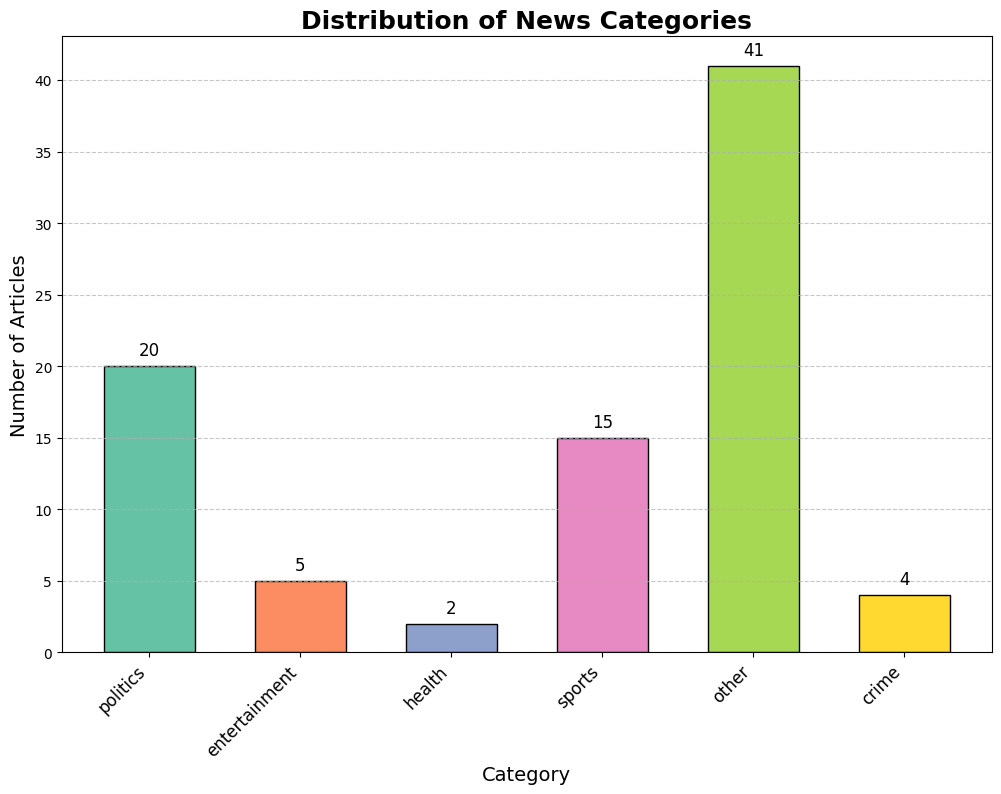

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate the number of articles in each category
category_counts = data['category'].value_counts()

# Map categories to their cluster numbers for plotting
category_cluster_order = data.groupby('category')['unique_cluster'].mean().sort_values().index
category_counts = category_counts.loc[category_cluster_order]

# Choose a color palette
colors = sns.color_palette('Set2', len(category_counts))

# Create the bar chart
plt.figure(figsize=(12, 8))  # Adjust the size to fit the data well
bar_width = 0.6  # Adjust this value to make bars narrower or wider
plt.bar(category_counts.index, category_counts.values, color=colors, edgecolor='black', width=bar_width)

# Add title and labels
plt.title('Distribution of News Categories', fontsize=18, fontweight='bold')
plt.xlabel('Category', fontsize=14)
plt.ylabel('Number of Articles', fontsize=14)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right', fontsize=12)

# Add value labels on top of each bar
for i, value in enumerate(category_counts):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=12)

# Add gridlines on y-axis
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.show()


In [50]:
from google.colab import files
# Download the CSV file
files.download('MyFinalOutput.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>